# Confidence Intervals for Estimates

If we estimate parameters of a distribution from a data set and only return the estimated values, those are called point estimates. Point estimates are limited in their usefulness because they do not give any indication of the reliability of those estimates. To provide more information, it is helpful to specify confidence intervals for the parameters.

## Bootstrap Confidence Intervals for Estimates

Confidence intervals are easily generated for any parameter estimates by using bootstrap sampling. To generate a C% confidence interval, the bootstrap distribution of the estimator is generated and then a region containing the center C% of the probability is determined.  If you have been following along in the text, you are probably capable by now of generating a C% bootstrap confidence interval based on that brief description. If you feel less confident, you can reveal a more detailed description of the procedure below:

```{admonition} Click to reveal algorithm for generating bootstrap confidence intervals
:class: dropdown

1. Choose a number of simulated values, which is the number of values in the bootstrap distribution.
2. Create an empty array or empty list to store the values in the bootstrap distribution.
2. For each simulated value:
    1. Draw a bootstrap sample from the data. The bootstrap sample should be the same size as the original data and be drawn **with replacement**.
    2. Compute the parameter estimate from the bootstrap sample.
    3. Store the parameter estimate in the array of values for the bootstrap distribution.
3. Determine the interval that contains the center C% probability of the data.
```





Let's illustrate this with an example. Start by importing some of the usual libraries we will need in this section:

In [1]:
import numpy as np
import numpy.random as npr
import scipy.stats as stats
import matplotlib.pyplot as plt

The code below takes data and a confidence interval and provides a point estimate and a confidence interval for the mean of the distribution of the data: 

In [2]:
def find_mean_CI(x, C):

  n = len(x)

  alpha = (100 - C)/2

  avg = x.mean()

  # Now do bootstrap sampling
  # Start by specifying the number of bootstrap values to simulate
  num_bs_sims = 1000

  # Create an array of zeros to store the bootstrap values
  bs_averages = np.zeros(num_bs_sims)

  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(x, n)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg

  # Now find the values that define the C%  
  percentiles = np.percentile(bs_averages, [alpha, 100-alpha])

  print(f'The mean estimate is {avg:.2f}')
  print(f'A {C}% confidence interval for the average is [{percentiles[0]: .2f}, {percentiles[1]:.2f}]')

Here are the 90%, 95%, and 99% confidence intervals for the mean estimate of a small example data set:

In [3]:
x = np.array([ 1, 1.2, 1.4, 1.2, 1, 1.2, 1.5, 1.45, 1.05, 1.65, 1.8])
find_mean_CI(x, 90)

The mean estimate is 1.31
A 90% confidence interval for the average is [ 1.19, 1.45]


In [4]:
find_mean_CI(x, 95)

The mean estimate is 1.31
A 95% confidence interval for the average is [ 1.16, 1.48]


In [5]:
find_mean_CI(x, 99)

The mean estimate is 1.31
A 99% confidence interval for the average is [ 1.13, 1.51]


Note that the confidence interval will be larger for larger confidence C in order to ensure that C% of the bootstrap distribution is within the interval.

It is important to again remind ourselves of what a C% confidence interval means. In particular, it does not mean that there is a C% probability that a particular confidence interval contains the true mean. Rather, it means that over the long run, the true mean would lie in C% of the confidence intervals that are generated according to this procedure. 

For data sample sizes of less than approximately 100, the C% confidence intervals generated via bootstrap sampling are generally not wide enough to achieve the specified confidence. Let's illustrate this with an experiment:


In the simulation below, a data sample of 10 random values is drawn from a Normal(1, 2) distribution. Then the sample mean is calculated, and bootstrap sampling is used to also generate a 95% confidence interval. This process is repeated to show the sample mean and the confidence interval for 25 different random samples. The star marker indicates the average (sample mean) of the data, and the vertical line indicates the true mean (1). Confidence intervals that contain the true mean are indicated as solid, green lines; confidence intervals that do not contain the true mean are indicated by dashed, red/orange lines.  



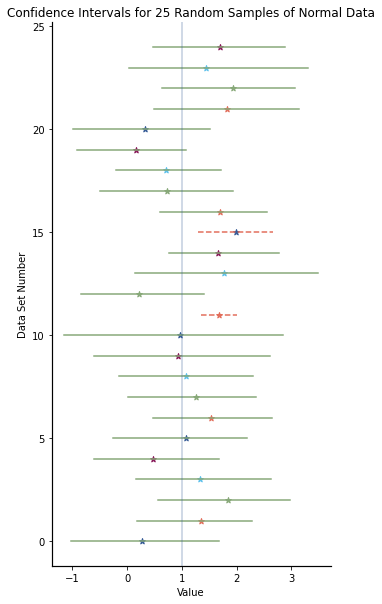

In [6]:
npr.seed(5678)

num_data_samples = 25
data_size = 10

# The confidence, C:
C = 95

alpha = (100 - C)/2

X = stats.norm(1,2 )

plt.figure(figsize = (5,10) )
for sim in range(num_data_samples):
  Xvals = X.rvs(data_size)
  avg = Xvals.mean()
  
  # Now do bootstrap sampling
  # Start by specifying the number of bootstrap values to simulate
  num_bs_sims = 1000
  
  # Create an array of zeros to store the bootstrap values
  bs_averages = np.zeros(num_bs_sims)
  
  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(Xvals, data_size)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg
  
  # Now find the values that define the C%  
  percentiles = np.percentile(bs_averages, [alpha, 100-alpha])
  if percentiles[0] <= 1 and percentiles[1] >=1:
    plt.plot(percentiles, [sim, sim], color='C2')
  else:
    plt.plot(percentiles, [sim, sim], color='C1', linestyle='--')
  plt.scatter(avg, sim, marker='*')
 
plt.axvline(1, alpha=0.3)
plt.ylabel('Data Set Number');
plt.xlabel('Value');
plt.title('Confidence Intervals for 25 Random Samples of Normal Data');


For the seed I arbitrarily chose, 2 out of 25 confidence intervals did not contain the true mean, which is 8%. In the long run, we expect at least 5% of confidence intervals to not contain the true mean, and the bootstrap estimator for CIs is not conservative enough for small data, so 8% may be accurate. The following simulation provides a more accurate estimate of the probability that the CI contains the true mean by running 1,000 simulations:

In [7]:
num_sims = 2000
data_size = 10

X = stats.norm(1,2 )

num_miss_true_mean = 0
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  avg = Xvals.mean()
  
  # Now do bootstrap sampling
  num_bs_sims = 1000
  bs_averages = np.zeros(num_bs_sims)
  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(Xvals, data_size)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg
    
  percentiles = np.percentile(bs_averages, [2.5, 97.5])
  if percentiles[0] > 1 or percentiles[1] <1:
    num_miss_true_mean += 1

print('The probabilty a bootstrap CI does not contain the true mean is' 
      + f'{num_miss_true_mean/num_sims : 0.2f}')

The probabilty a bootstrap CI does not contain the true mean is 0.10


We see that the actual that a bootstrap CI does not contain the true mean for this distribution is around 11%, when our target was 5%. Below is a table that shows the probability[^ci_probs] that a bootstrap sample does not contain the true mean for this distribution as a function of $N$:

| Data Size ($N$) | Probability CI does not contain true mean |
| :-: | :-: |
| 5 | 16.3% |
| 10 | 10.0% |
| 25 | 6.9% |
| 50 | 5.9% |
| 75 | 5.6% |
| 100 | 5.5% |

Based on this distribution, bootstrap confidence intervals can only be considered accurate if they are generated from more than 100 data samples. However, better confidence intervals can be generated through bootstrap sampling using algorithms such as the $\mbox{BC}_\alpha$ method or $\mbox{ABC}$ method[^efron_book], which are available in the Python [bootstrap-stat library](https://pypi.org/project/bootstrap-stat/).

We will continue to use percentile-based bootstrap confidence intervals in this book for simplicity, but readers who need more accurate results should use one of the two algorithms mentioned above.

[^ci_probs]: These probabilities are approximations; they were estimated via simulations of 100,000 random samples of the data for each data size.

[^efron_book]: See Chapter 14 of *An Introduction to the Bootstrap* by Bradley Efron and Robert J. Tibshirani, Chapman & Hall/CRC, 1993.

In [8]:
from numba import jit


In [9]:
@jit
def sim_ci(data_size=5, num_sims=100_000):

  num_bs_sims = 1000
  X = stats.norm(1,2 )

  num_miss_true_mean = 0
  Xvals = X.rvs((num_sims, data_size))
  avgs = Xvals.mean(axis=1)
  bs_averages = np.zeros(num_bs_sims)
  for sim in range(num_sims):

    # Do bootstrap sampling

    for bs_sim in range(num_bs_sims):
      bs_sample = npr.choice(Xvals[sim], data_size)
      bs_avg = bs_sample.mean()
      bs_averages[bs_sim] = bs_avg

    percentiles = np.percentile(bs_averages, [2.5, 97.5])
    if percentiles[0] > 1 or percentiles[1] <1:
      num_miss_true_mean += 1

  #print('The probabilty a bootstrap CI does not contain the true mean is' 
       # + f'{num_miss_true_mean/num_sims*100 : 0.2f}')
  return num_miss_true_mean/num_sims*100

In [10]:
for data_size in [5, 10, 25, 50, 75, 100]:
  print(data_size, f'{sim_ci(data_size) : 0.1f}' )

/var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_28282/4212116520.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sim_ci" failed type inference due to: Unknown attribute 'norm' of type Module(<module 'scipy.stats' from '/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/__init__.py'>)

File "../../../../../../../../var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_28282/4212116520.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at /var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_28282/4212116520.py (5)

File "../../../../../../../../var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_28282/4212116520.py", line 5:
<source missing, REPL/exec in use?>

  @jit
/var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_28282/4212116520.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "sim_ci" f

5  16.3
10  9.9
25  6.9
50  6.0
75  5.6
100  5.5


## Analytical Confidence Intervals for Mean Estimates

The mean is special because of the Central Limit Theorem (see {doc}`Section 8.7.3.2<../08-random-variables/important-continuous-rvs>`) -- regardless of the type of distribution of the underlying data[^clt], the distribution of the sample mean estimator will be approximately Normal if there are at least tens of data points. Given the distribution of the estimator, we can use analytical approaches as an alternative to bootstrap estimators. The first step is to characterize the parameters of the distribution of the sample mean estimator.

[^clt]: Actually the distribution will have to satisfy some mild restrictions, such as having finite mean and variance.

### Linear Combinations of Independent Gaussian RVs

Suppose we have a  data sample $\mathbf{X}=\left[X_0,X_1,\cdots,X_{n_X-1} \right]$, where different values in the sample are assumed to be independent[^ci]. We know from above that the sample mean estimator is unbiased. Thus, the expected value of the sample mean estimator is the true mean. We will also need the variance of the sample mean estimator in our analysis. Let $\sigma_{X}^2$ be the variance of the $X_i$. Then the variance of the sample mean estimator is 
\begin{align*}
\operatorname{Var} \left[ \hat{\mu}_X \right] &= \operatorname{Var} \left[ \frac 1 {n_X} \sum_{i=0}^{n_X-1} X_i \right] \\
&= \frac 1 {n_{X}^2} \operatorname{Var} \left[  \sum_{i=0}^{n_X-1} X_i \right], \\
\end{align*}
where the second line of the equation follows from Property 3 of variance (see {doc}`Section 9.3.4<moments>`). Since the random variables in $\mathbf{X}$ are independent, we can apply Property 4 of variance to get
\begin{align*}
\operatorname{Var} \left[ \hat{\mu}_X \right] &= \frac 1 {n_{X}^2}  \sum_{i=0}^{n_{X}-1} \operatorname{Var} \left[  X_i \right] \\
&= \frac 1 {n_{X}^2}  \sum_{i=0}^{n_{X}-1} \sigma_{X}^2\\
&= \frac 1 {n_{X}^2}  n_{X} \sigma_{X}^2\\
&= \frac {\sigma_{X}^2} {n_{X}}  .
\end{align*}
The variance of the sample mean estimator decreases linearly with the number of samples. (This can be used to show that the sample mean estimator converges to the true mean as $n_{X} \rightarrow \infty$ if $\sigma_{X}^2$ is finite.)

The analysis above is sufficient to characterize $\hat{\mu}_X$ :
\begin{align*}
\hat{\mu}_X \sim \mbox{Normal} \left(\mu_X, \frac{\sigma_X}{\sqrt{n_X}} \right) .
\end{align*}


Note however, that $\mu_X$ is unknown (it is the parameter we are trying to estimate), and $\sigma_X$ may be known but is more often also unknown and must be estimated from the data. The analysis of the confidence intervals is different depending on whether the standard deviation of the data is known or unknown.

### Confidence Intervals for Mean Estimate with Known Data Variance

Recall that given a specified confidence $C$%, we wish to create a procedure that for each data sample $\mathbf{x}$ will determine an interval $I_C$ such that $P( \mu_X \in I_C) = C\%$, where $\mu_X$ is the true mean, which is unknown. Then for a particular data sample $\mathbf{x}$ with average $\overline{\mathbf{x}}$, we can calculate the probability of observing an average "as extreme" as $\overline{\mathbf{x}}$ for any given value of $\mu_X$. 

\begin{align*}
P\left( \mu  \in \left( \hat{\mu}_X -d, \hat{\mu}_X +d \right] \right) \\
P\left(  \hat{\mu}_X -d \le \mu \cap \hat{\mu}_X +d > \mu \right) \\
P\left(  \hat{\mu}_X  - \mu \le d \cap \hat{\mu}_X -\mu  > -d\right) \\
\end{align*}

Observing that $\hat{\mu}_X-\mu$ has mean zero, we start by rewriting this expression in terms of tail probabilities:
\begin{align*}
P\left(  \hat{\mu}_X  - \mu \le d \cap \hat{\mu}_X -\mu  > -d\right)  &= 
1 - P\left(  \hat{\mu}_X  - \mu > d \cup \hat{\mu}_X -\mu  \le  -d\right) \\
&= 1 - P\left(  \hat{\mu}_X  - \mu > d \right) + P\left(\hat{\mu}_X -\mu  \le  -d\right),
\end{align*}
where the second line comes from the fact that we are asking about the probability that $\hat{\mu}_X -\mu $ is in mutually exclusive regions of the real line, which results in mutually exclusive events. Next note that under the assumption that $\hat{\mu}_X - \mu$ is normal with mean 0, the pdf of $\hat{\mu}_X - \mu$  is symmetric around $x=0$. We can use this symmetry to write 
\begin{align*}
 1 - P\left(  \hat{\mu}_X  - \mu > d\right) + P\left(\hat{\mu}_X -\mu  \le  -d\right) =  1 - 2 P\left(  \hat{\mu}_X  - \mu > d \right).
\end{align*}

Then for a given confidence C, we have 
\begin{align*}
 1 - 2 P\left(  \hat{\mu}_X  - \mu > d \right) &= C \\
 P\left(  \hat{\mu}_X  - \mu > d \right) = \frac{1-C}{2}.
\end{align*}
For future convenience, let $\alpha = (1-C)/2$.

We have several ways to proceed from here. One approach is to create a SciPy distribution for the random variable $\hat{\mu}_X  - \mu$, which we know is Normal with mean 0. The variance of  $\hat{\mu}_X$ is $\sigma_{X}^2/\sqrt{n}$, and this is also the variance of  $\hat{\mu}_X  - \mu$ by Property 2 of variance. Note that the probability is in the form of a survival function, which is the $Q$ function for a Normal random variable. Since we have SciPy available, the simplest and most direct way is to make a Normal distribution object with the appropriate mean and variance and use the inverse survival function method `isf()` to solve for the value of $d$. The code below shows hot to find the value of $d$ for a 95% confidence interval when $\sigma=2$:

In [11]:
x_var = np.var(x, ddof=1)
n = 10
alpha = (1-0.95)/2

T = stats.norm(loc = 0, scale = 2 / np.sqrt(n) )
T.isf(alpha)

1.2395900646091231

As an alternative to setting up a Normal random variable with the specified standard deviation and using the `isf()` function, we can express the probability analytically in terms of the $Q$ function as 
\begin{align*}
 Q\left(  \hat{\mu}_X  - \mu > d \right) &= \alpha \\
 \frac d {\sigma_x/\sqrt{n_x}}  &= Q^{-1} \left(\alpha \right) \\
d &= \frac{\sigma_x}{\sqrt{n_x}} Q^{-1} \left(\alpha \right) \\
\end{align*}



Then we can use our usual definition of the $Q$ function in Python to calculate the value of $d$. The code below shows how the calculation for the same scenario of $C=95$% and $\sigma_X=2$:

In [12]:
def qinv(x):
  return stats.norm.isf(x)

In [13]:
sigma_x = 2
n = 10
alpha = (1-0.95)/2


sigma_x / np.sqrt(n) * qinv(alpha)


1.2395900646091231

The figure below compares the bootstrap confidence interval to the analytical confidence interval for the same data as in the previous example, which considered only bootstrapping.


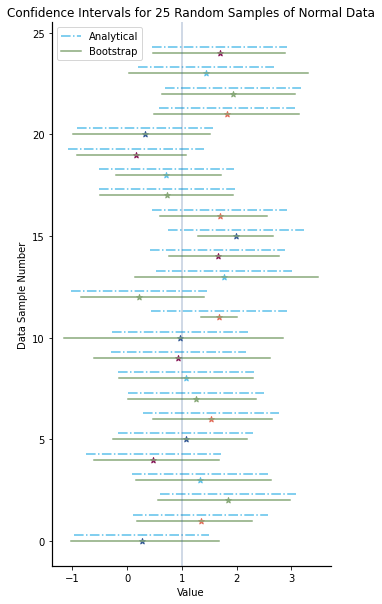

In [14]:
npr.seed(5678)

num_sims = 25
data_size = 10

X = stats.norm(1,2 )
d = 2 / np.sqrt(10) * qinv((1-0.95)/2)

plt.figure(figsize = (5,10) )
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  avg = Xvals.mean()
  
  # Now do bootstrap sampling
  num_bs_sims = 1000
  bs_averages = np.zeros(num_bs_sims)
  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(Xvals, data_size)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg
    
  percentiles = np.percentile(bs_averages, [2.5, 97.5])

  if sim ==0:
    plt.plot([avg-d, avg+d], [sim+0.3, sim+0.3], color='C3', linestyle='-.', label = 'Analytical')
    plt.plot(percentiles, [sim, sim], color='C2', label = 'Bootstrap')
  else:
    plt.plot(percentiles, [sim, sim], color='C2')
    plt.plot([avg-d, avg+d], [sim+0.3, sim+0.3], color='C3', linestyle='-.')
    
  plt.scatter(avg, sim, marker='*')
 
plt.axvline(1, alpha=0.3)
plt.ylabel('Data Sample Number');
plt.xlabel('Value');
plt.legend();
plt.title('Confidence Intervals for 25 Random Samples of Normal Data');


Note that for most of the results, the confidence intervals returned by the bootstrap algorithm and the analytical result are approximately equal. However, there are several important differences. In particular, the bootstrap algorithm produces two confidence intervals that are much narrower than the analytical confidence intervals and that do not include the true mean -- these are for data samples 11 and 15. The smaller bootstrap confidence intervals can be attributed to those data sample having a much smaller sample variance than the variance of the distribution from which they came. Recall that the data comes from a distribution with standard deviation of 2, corresponding to a variance of 4. The figure below shows the sample variances for each of the data samples in this example, with the values for samples 11 and 15 highlighted in orange:

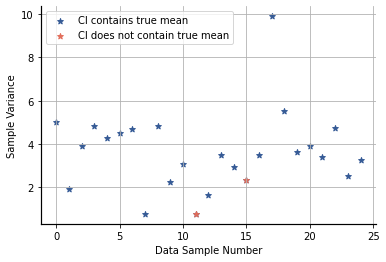

In [15]:
npr.seed(5678)

num_sims = 25
data_size = 10

X = stats.norm(1,2 )
small_cis=[11, 15]

plt.figure()#figsize = (5,10) )
variances = []
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  #avg = Xvals.mean()
  var = Xvals.var(ddof=1)
  variances += [var]
      
plt.scatter(range(num_sims), variances, marker='*', label='CI contains true mean')

for sim in small_cis:
  if sim == small_cis[0]:
    plt.scatter(sim, variances[sim], marker='*', color='C1', label='CI does not contain true mean')
  else:
        plt.scatter(sim, variances[sim], marker='*', color='C1')
plt.grid();

 
# plt.axvline(1, alpha=0.3)
plt.xlabel('Data Sample Number');
plt.ylabel('Sample Variance');
plt.legend();
# plt.title('Confidence Intervals for 25 Random Samples of Normal Data');



Note that having a low sample variance does not necessarily imply that the bootstrap confidence interval will be small. The sample variance for data sample 7 is similar to that of data sample 11, and yet the confidence interval for data sample 7 is not that smaller than the analytical result. This can be attributed to the fact that the bootstrap uses all of the information in the data rather than just the variance when creating the confidence intervals.

This example shows that analysis can produce better estimates of confidence intervals, but it **required that the standard deviation of the distribution be known**. In most practical examples, this is not the case, and the standard deviation or variance must be estimated from the data. 

### Confidence Intervals for Mean Estimate with Unknown Data Variance

If the standard deviation or variance of the distribution is not known, then we must estimate it. We will use the unbiased variance estimator, 
\begin{align*}
S_{n-1}^2 = \frac{1}{n-1}\sum_{i=0}^{n-1} \left(X_i-\hat{\mu}_X \right)^2.
\end{align*}


Recall that if $\hat{\mu}_X$ is Normal( $\mu_X, \sigma_X)$ , then 
```{math}
:label: normalized1
\frac{ X  - \mu_X}{\sigma_X} \sim \mbox{Normal}(0,1).
```
<!-- $$ \frac{ X  - \mu_X}{\sigma_X} \sim \mbox{Normal}(0,1). $$-->

If we have to replace the true variance by its estimator, then the distribution changes. Using the unbiased variance estimator instead of the true variance, the distribution of
```{math}
:label: normalized2
\frac{\hat{\mu}-\mu_X }{S_{n-1}/\sqrt{n}}
```
has a **Student’s $t$-distribution with $\nu = n-1$ degrees of freedom (dof)**.  For convenience, we will denote this distribution by $t_\nu$.


The density and distribution functions are complicated and omitted here, but you can find them on the [Wikipedia page for Student's $t$-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution). Fortunately for us, SciPy.stats has the functions we will need in our analysis built in. An additional point of good news is that unlike the Gaussian distribution, the distribution function for Student’s t-distribution is in closed form for several values of the dof parameter.

```{note}
Note that normalizing by the true mean and variance, as in  {eq}`normalized1` results in a random variable with mean 0 and variance 1. 

The normalization in {eq}`normalized2` results in a random variable with mean 0 and variance equal to $\nu/(\nu-2)$ for $\nu>2$, where $\nu=n-1$ is the number of degrees of freedom of the Student's $t$ distribution. Note that the variance of the Student's $t$ distribution is always greater than 1 but converges to 1 as $\nu$ goes to $\infty$.
```

From the increased variance of the Student's $t$ distribution, we expect that the Student's $t$ density is in some sense more spread out than the Normal distribution.  Let's compare the standard Normal(0,1) density to the Student's $t$ density with different dofs:

In [16]:

norm=stats.norm()
t1=stats.t(1)
t2=stats.t(2)
t5=stats.t(5)
tinf=stats.t(100000)

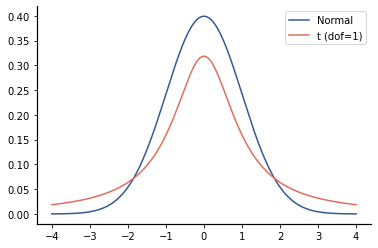

In [17]:
x=np.linspace(-4,4,1000)
plt.plot(x,norm.pdf(x),label='Normal')
plt.plot(x,t1.pdf(x),label='t (dof=1)')
plt.legend();

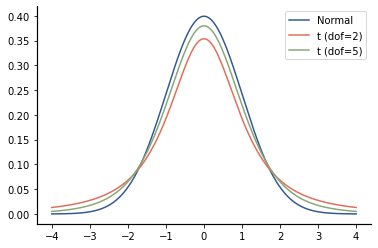

In [18]:
x=np.linspace(-4,4,1000)
plt.plot(x,norm.pdf(x),label='Normal')
plt.plot(x,t2.pdf(x),label='t (dof=2)')
plt.plot(x,t5.pdf(x),label='t (dof=5)')
plt.legend();

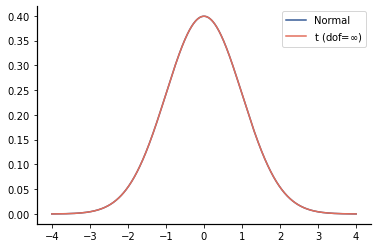

In [19]:
x=np.linspace(-4,4,1000)
plt.plot(x,norm.pdf(x),label='Normal')
plt.plot(x,tinf.pdf(x),label='t (dof=$\infty$)')
plt.legend();

For small dofs, the Student's $t$ density has much more probability in the tails of the distribution than the Normal density does. As $N \rightarrow \infty$, the Student's $t$ density converges to the Normal density.

**JMS: WORKING HERE**

If we want to generate a SciPy distribution for a Student's $t$ variable of the form in {eq}`normalized2`, then we can generate a corresponding SciPy distribution by setting the following parameters:
* the `df` parameter is set to the number of degrees of freedom, $\nu=n-1$
* the `loc` parameter is set to the true mean, $\mu_X$, and
* the `scale` parameter  is set to the observed value of $S^{2}_{n-1}/\sqrt{n}$.

For instance, we will often be working with a $t$ variable with mean 0. If we have data in a variable `x`, then we can generate a SciPy $t$-distribution as follows:

In [20]:
# Some sample data
x = [-9, -4, 1, 4, 9, 16]

n = len(x)
sigma_t = np.std(x, ddof=1) / np.sqrt(len(x))
T = stats.t(df = n-1, scale = sigma_t)

The average value is

In [21]:
np.mean(x)

2.8333333333333335

If the true mean were 0, the probability of seeing such a large value of the mean can be computed using the `T` object as

In [22]:
T.sf(np.mean(x))

0.23717425447353055

To create analytical confidence intervals with the standard deviation estimated from the data, we can again find a region $\left(\hat{\mu}_X -d, \hat{\mu}_X+d \right]$ that satisifies
\begin{align*}
 P\left(  \hat{\mu}_X  - \mu > d \right) = \alpha,
\end{align*}
where $\alpha = (1-C)/2$. However, $\hat{\mu}_X - \mu$ is not longer Normal. It will have a Student's $t$ distribution if we normalize it by dividing by {S_{n-1}/\sqrt{n}}. In practice, we perform this normalization using the *observed* standard deviation estimate, $s_{n-1}$ in place of the random estimator. Then we can use SciPy to create a Student's $t$ distribution with the appropriate degrees of freedom and scaling, and then use the `isf()` method to find the value of $d$.

This will be most clear using an example. The data below is the first data sample from the confidence intervals above:


In [23]:
# The data
x= np.array([-0.41957876,  0.96561764,  1.63882274, -3.53066214, -1.75490733,
        4.89996147, -0.12762015, -0.68747518,  1.44907716,  0.21724457])
n=len(x)

# Set C and calculate alpha
C = 95/100
alpha = (1-C)/2

# Calculate the standard deviation estimate
s = np.std(x, ddof=1)

# Now create the scaled Student's t distribution object using SciPy
T = stats.t(df = n - 1, scale=s/np.sqrt(n) )

# And now find the value of d using the inverse survival function
T.isf(alpha)

1.6046001899833675

This compares to a $d$ of 1.24 when the variance is known and we can use the Normal distribution. 

The figure below shows the confidence intervals for all three methods: bootstrap, analytical with  known variance, and analytical with unknown variance:

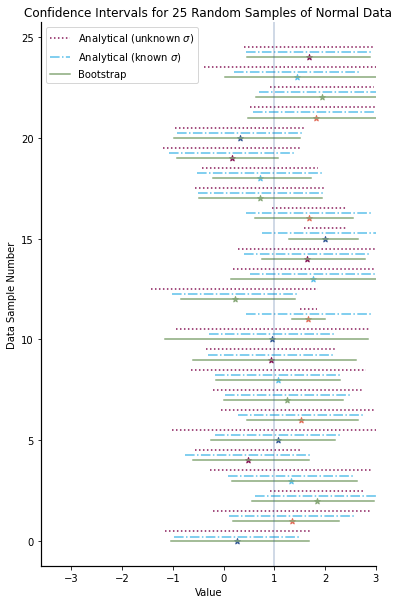

In [24]:
npr.seed(5678)

num_sims = 25
data_size = 10

C=95
alpha = (1-C/100)/2


X = stats.norm(1,2 )
d = 2 / np.sqrt(data_size) * qinv(alpha)

plt.figure(figsize = (6,10) )
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  avg = Xvals.mean()
  
  # Now do bootstrap sampling
  num_bs_sims = 1000
  bs_averages = np.zeros(num_bs_sims)
  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(Xvals, data_size)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg
    
  percentiles = np.percentile(bs_averages, [100*alpha, 100*(1-alpha)])

  # Add Student's t approach
  s = np.std(bs_sample, ddof=1)
  T = stats.t(df = data_size-1, scale=s/np.sqrt(data_size) )
  d2 = T.isf(alpha)
  if sim ==0:
    plt.plot([avg-d2, avg+d2], [sim+0.5, sim+0.5], color='C4', linestyle=':', label = 'Analytical (unknown $\sigma$)')
    plt.plot([avg-d, avg+d], [sim+0.2, sim+0.2], color='C3', linestyle='-.', label = 'Analytical (known $\sigma$)')
    plt.plot(percentiles, [sim, sim], color='C2', label = 'Bootstrap')
  else:
    plt.plot([avg-d2, avg+d2], [sim+0.5, sim+0.5], color='C4', linestyle=':')
    plt.plot(percentiles, [sim, sim], color='C2')
    plt.plot([avg-d, avg+d], [sim+0.25, sim+0.25], color='C3', linestyle='-.')
    
  plt.scatter(avg, sim, marker='*')
 
plt.axvline(1, alpha=0.3)
plt.ylabel('Data Sample Number');
plt.xlabel('Value');
plt.legend();
plt.xlim(-3.6, 3);
plt.title('Confidence Intervals for 25 Random Samples of Normal Data');


Note that the confidence intervals produced using the Student's $t$ distribution are very similar to those produced by bootstrap sampling because the width of the confidence interval is now determined from the data. Data samples 11 and 15 both do not include the true mean for this analytical model. Just like the bootstrap confidence intervals, the Student's $t$ model does not provide conservative enough confidence intervals for small data samples. Various correction factors are available in the literature to provide better confidence intervals for small data samples.

In the next section, we consider how to apply some of these ideas to test if two data samples have different means.